<a href="https://colab.research.google.com/github/Kimuksung/bigdata/blob/master/plant_RNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)  

Mounted at /gdrive


In [0]:
import pandas as pd
from datetime import datetime , timedelta

plant1_train = pd.read_csv("/gdrive/My Drive/Plain/plant1_train.csv")
plant2_train = pd.read_csv("/gdrive/My Drive/Plain/plant2_train.csv")

In [0]:
plant1_train = plant1_train.drop('Unnamed: 0' , axis=1)
cols = ['Date' , 'loc1_tem', 'loc1_hum', 'loc1_coil_temp','loc2_tem', 'loc2_hum', 'loc2_coil_temp' , 'loc3_tem', 'loc3_hum', 'loc3_coil_temp', 'out_tem', 'out_hum', 'loc1' , 'loc2' , 'loc3']
plant1_train.columns = cols

plant1_train_first = plant1_train[['Date','loc1_tem', 'out_tem' , 'loc1_coil_temp','loc1_hum' ,'out_hum','loc1']]

a = datetime.strptime(plant1_train_first['Date'][0]  , '%Y-%m-%d %H:%M')

date_trans = []
for i in range(0,len(plant1_train_first)):
    date_trans.append(datetime.strptime(plant1_train_first['Date'][i] , '%Y-%m-%d %H:%M'))

plant1_train_first['date_trans'] = date_trans
plant1_train_first

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date,loc1_tem,out_tem,loc1_coil_temp,loc1_hum,out_hum,loc1,date_trans
0,2016-04-01 0:00,16.00,9.00,11.00,24.00,42.00,0.0,2016-04-01 00:00:00
1,2016-04-01 3:00,14.00,7.00,10.00,28.00,59.00,0.0,2016-04-01 03:00:00
2,2016-04-01 6:00,13.00,6.00,10.00,33.00,56.00,0.0,2016-04-01 06:00:00
3,2016-04-01 9:00,13.00,18.00,10.00,33.00,30.00,0.0,2016-04-01 09:00:00
4,2016-04-01 12:00,16.00,18.00,10.00,28.00,20.00,0.0,2016-04-01 12:00:00
...,...,...,...,...,...,...,...,...
58744,2019-03-31 23:10,10.52,6.40,10.52,36.39,43.86,0.0,2019-03-31 23:10:00
58745,2019-03-31 23:20,10.52,6.34,10.44,37.09,44.02,0.0,2019-03-31 23:20:00
58746,2019-03-31 23:30,10.43,6.40,10.56,37.18,43.04,0.0,2019-03-31 23:30:00
58747,2019-03-31 23:40,10.49,6.31,10.56,38.00,45.33,0.0,2019-03-31 23:40:00


In [0]:
temp = plant1_train_first
temp2 = temp.set_index('date_trans')
hour3 = temp2.resample('3H').first()

hour3['dayofyear'] = hour3.index.dayofyear
hour3['dayofhour'] = hour3.index.hour
hour3['nextdayhum'] = hour3.out_hum.shift(-8)

# 선형 보간
hour3['loc1_tem'] = hour3['loc1_tem'].interpolate(method='linear')
hour3['out_tem'] = hour3['out_tem'].interpolate(method='linear')
hour3['loc1_coil_temp'] = hour3['loc1_coil_temp'].interpolate(method='linear')
hour3['loc1_hum'] = hour3['loc1_hum'].interpolate(method='linear')
hour3['out_hum'] = hour3['out_hum'].interpolate(method='linear')
hour3['nextdayhum'] = hour3['nextdayhum'].interpolate(method='linear')

print(hour3.isnull().sum())
# df -> np
y_data = hour3['nextdayhum'].values[0:-8].reshape(-1, 1)
hour3 = hour3.drop(["Date" , "loc1", "nextdayhum"] , axis = 1)
type(hour3) # dataframe

type(hour3.values[0:-8]) #numpy
x_data = hour3.values[0:-8]

x_data.shape
y_data.shape

Date               52
loc1_tem            0
out_tem             0
loc1_coil_temp      0
loc1_hum            0
out_hum             0
loc1              388
dayofyear           0
dayofhour           0
nextdayhum          0
dtype: int64


(8752, 1)

In [0]:
hour3[:10]

,loc1_tem,out_tem,loc1_coil_temp,loc1_hum,out_hum,dayofyear,dayofhour
date_trans,,,,,,,
2016-04-01 00:00:00,16.0,9.0,11.0,24.0,42.0,92,0
2016-04-01 03:00:00,14.0,7.0,10.0,28.0,59.0,92,3
2016-04-01 06:00:00,13.0,6.0,10.0,33.0,56.0,92,6
2016-04-01 09:00:00,13.0,18.0,10.0,33.0,30.0,92,9
2016-04-01 12:00:00,16.0,18.0,10.0,28.0,20.0,92,12
2016-04-01 15:00:00,18.0,17.0,14.0,24.0,23.0,92,15
2016-04-01 18:00:00,17.0,12.0,14.0,28.0,52.0,92,18
2016-04-01 21:00:00,16.0,11.0,12.0,38.0,55.0,92,21
2016-04-02 00:00:00,15.0,10.0,12.0,41.0,57.0,93,0


In [0]:
num_data = len(x_data)
train_split = 0.8

num_train = int(train_split * num_data) # 7001
num_test = num_data - num_train # 1751

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]
num_y_signals = 1

import numpy as np
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -13.57
Max: 366.0


In [0]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print("x_train_scale_shape:" , x_train_scaled.shape)
print("y_train_scale_shape:" ,y_train_scaled.shape)

print("y_test_scale_shape:" ,y_test_scaled.shape)

Min: 0.0
Max: 1.0
x_train_scale_shape: (7001, 7)
y_train_scale_shape: (7001, 1)
y_test_scale_shape: (1751, 1)


In [0]:
def batch_generator(batch_size, sequence_length):
    while True:
    # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
        # Get a random start-index.
        # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
               
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

x_batch :  (256, 448, 7)
y_batch :  (256, 448, 1)
(1, 1751, 7)
(1, 1751, 1)


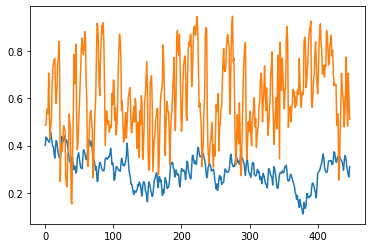

In [0]:
from matplotlib import pyplot as plt
batch_size = 256
sequence_length = 8 * 7 * 8

generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)
x_batch, y_batch = next(generator)

print("x_batch : ",x_batch.shape)
print("y_batch : ",y_batch.shape)

batch = 0 # First sequence in the batch.
signal = 0 # First signal from the 7 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

seq2 = y_batch[batch, :, signal]
plt.plot(seq2)

validation_data = (np.expand_dims(x_test_scaled, axis=0), np.expand_dims(y_test_scaled, axis=0))    

print(np.expand_dims(x_test_scaled, axis=0).shape)
print(np.expand_dims(y_test_scaled, axis=0).shape)

In [0]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
model.add(Dense(1, activation='sigmoid'))

In [0]:
warmup_steps = 50

def loss_mse_warmup(y_true, y_pred):
     y_true_slice = y_true[:, warmup_steps:, :]
     y_pred_slice = y_pred[:, warmup_steps:, :]
     # These sliced tensors both have this shape:
     # [batch_size, sequence_length - warmup_steps, num_y_signals]
     # Calculate the MSE loss for each value in these tensors.
     # This outputs a 3-rank tensor of the same shape.
     #loss = tf.losses.mean_squared_error(labels=y_true_slice, predictions=y_pred_slice)
     loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
     # Keras may reduce this across the first axis (the batch)
     # but the semantics are unclear, so to be sure we use
     # the loss across the entire tensor, we reduce it to a
     # single scalar with the mean function.
     loss_mean = tf.reduce_mean(loss)
     return loss_mean

In [0]:
#optimizer = RMSprop(lr=1e-3)
optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         800256    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 800,769
Trainable params: 800,769
Non-trainable params: 0
_________________________________________________________________


In [0]:
import os
checkpoint_path = "/gdrive/My Drive/plant2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True)

In [0]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/', histogram_freq=0, write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-4,patience=0,verbose=1)
callbacks = [callback_early_stopping,callback_checkpoint,callback_tensorboard, callback_reduce_lr]

In [0]:
model.fit(x=generator,
 epochs=20,
 steps_per_epoch=100,
 validation_data=validation_data,
 callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0241 
Epoch 00001: val_loss improved from inf to 0.02428, saving model to /gdrive/My Drive/plant2/cp.ckpt
100/100 [==============================] - 1266s 13s/step - loss: 0.0241 - val_loss: 0.0243 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0208 
Epoch 00002: val_loss did not improve from 0.02428

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 1270s 13s/step - loss: 0.0208 - val_loss: 0.0252 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0197 
Epoch 00003: val_loss improved from 0.02428 to 0.02398, saving model to /gdrive/My Drive/plant2/cp.ckpt
100/100 [==============================] - 1266s 13s/step - loss: 0.0197 - val_loss: 0.0240 - lr: 1.0000e-04
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0194 
Epoch 00004: val_loss improved f

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0249


In [0]:
def plot_comparison(start_idx, length=100, train=True):
    if train:
        x = x_train_scaled
        y_true = y_train
    else:
        x = x_test_scaled
        y_true = y_test

    end_idx = start_idx + length

    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]

    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)

    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    for signal in range(1):
        signal_pred = y_pred_rescaled[:, signal]

        signal_true = y_true[:, signal]
        plt.figure(figsize=(15,5))

        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

        plt.legend()
        plt.show()

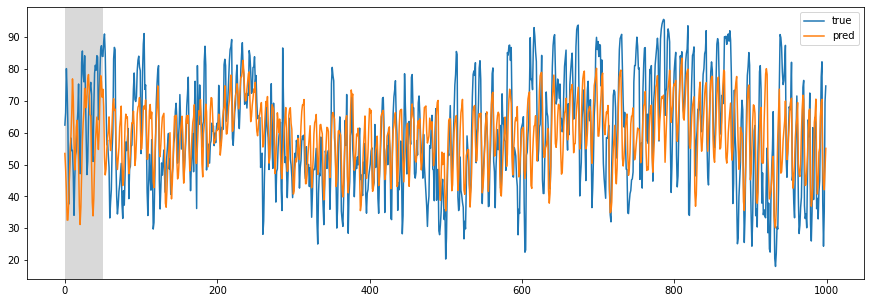

In [0]:
plot_comparison(start_idx = 5000, length=1000, train=True)

In [0]:
from sklearn.metrics import classification_report
y_true2 = y_test_scaled
x_test_scaled2 = np.expand_dims(x_test_scaled, axis=0)
y_pred = model.predict(x_test_scaled2)

y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
y_true3 = y_scaler.inverse_transform(y_true2)

pd.Series(np.squeeze(y_pred_rescaled))
pd.Series(np.squeeze(y_true3))
answer = pd.DataFrame({"true": pd.Series(np.squeeze(y_true3)) , "pred": pd.Series(np.squeeze(y_pred_rescaled))})
answer

,true,pred
0,82.30,66.004372
1,85.10,72.665871
2,63.25,73.655411
3,52.66,72.436470
4,58.79,70.282730
...,...,...
1746,37.18,65.181709
1747,36.26,54.677280
1748,36.05,52.698360
1749,36.23,59.548134


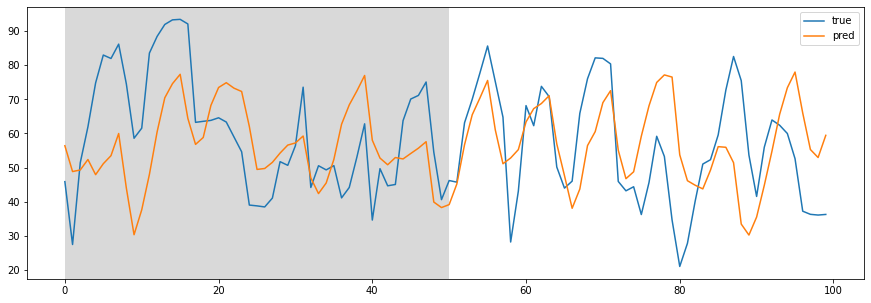

In [0]:
plot_comparison(start_idx = 1650, length=100, train=False)

In [0]:
from sklearn.metrics import r2_score

#r2_score(answer.true, answer['pred'])
r2_score(np.squeeze(y_true2) , np.squeeze(y_pred))
print(r2_score)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(np.squeeze(y_true2) , np.squeeze(y_pred))
mse

<function r2_score at 0x7ff3061511e0>


0.024664214157337643

In [0]:
r2_score(pd.Series(np.squeeze(y_true2)) , pd.Series(np.squeeze(y_pred)))


0.23959758012595755